## Wstęp do uczenia maszynowego 
### Praca domowa 4
#### Jakub Piwko, Malwina Wojewoda
***

### Pakiety

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import sklearn 
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
plt.rcParams['figure.figsize'] = (15,7)
import warnings
warnings.filterwarnings('ignore')
np.random.seed(23)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

### Wczytanie i analiza danych

Dane opisują Tajwańskie spółki z lat 1999-2009. Przewidujemy zmienną `Bankrupt?`, która wskazuje, czy dana spółka zbankrutuje. 

In [2]:
df = pd.read_csv('data.csv')

Jak wiemy z poprzedniego zadania domowego, w tym zbiorze nie występują braki danych.

In [3]:
#Wyróżnienie zbioru, na którym będziemy pracować i zbioru do walidacji
y_all = df["Bankrupt?"]
y_all = y_all.astype('int')
X_all = df.drop("Bankrupt?", axis=1)

X, X_val, y, y_val = train_test_split(X_all, y_all, random_state=420, test_size=0.3)

#Wyróżnienie zbioru treningowego i testowego
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
X_train_0 = copy.deepcopy(X_train)

Wykonamy teraz preprocesing z zadanie domowego nr 3 na tych danych:

In [5]:
def preprocessing(df, y):
    
    col_names = df.columns
    indexes_set = set()
    num_of_outliers = []

    for col in col_names:
        tmp_data1 = X_train_0[col]  #obcinamy tak samo jak na zbiorze treningowym
        upper_lim1 = tmp_data1.quantile(.975)
        lower_lim1 = tmp_data1.quantile(.025)
        df[col] = np.where(df[col] < upper_lim1, df[col], upper_lim1)
        df[col] = np.where(df[col] > lower_lim1, df[col], lower_lim1)

    cols_to_scale = []
    for col in col_names:
        if df[col].max() > 1:
            cols_to_scale.append(col)
    for col in cols_to_scale:
        min_max_scaler1 = MinMaxScaler()
        df[col] = min_max_scaler1.fit_transform(df[col].values.reshape(-1, 1))

    corr = X_train_0.corr(method = 'spearman') #usuwamy te same kolumny jak na zbiorze treningowym
    correlated_features = set()
    for i in range(len(corr .columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) >= 0.95:
                colname = corr.columns[i]
                correlated_features.add(colname)
    df.drop(labels=correlated_features, axis=1, inplace=True)
                
    df_y = pd.concat([df, y], axis=1)
    corr = df_y.corr(method = 'spearman')

    col_names = df_y.columns
    for col in col_names:
        if corr["Bankrupt?"][col] < 0:
            df[col] *= -1     
        
    return df

In [6]:
X_train = preprocessing(X_train, y_train)

In [7]:
X_test = preprocessing(X_test, y_test)

## Modele i dobór hiperparametrów 

In [8]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from scipy.stats import poisson,expon

In [9]:
def Scores(model, X, y):
    print(f"Model score: {model.score(X, y)}")
    print(f"Precision score: {precision_score(y, model.predict(X), average='binary')}")
    print(f"Gini score: {roc_auc_score(y, model.predict(X))}")

In [10]:
def print_scores(model):
    print(f"ZBIÓR TRENINGOWY:")
    print(f"Model score: {model.score(X_train, y_train)}")
    print(f"Precision score: {precision_score(y_train, model.predict(X_train), average='binary')}")
    print(f"Gini score: {roc_auc_score(y_train, model.predict(X_train))}")
    print("-------------------------------")
    print(f"ZBIÓR TESTOWY:")
    print(f"Model score: {model.score(X_test, y_test)}")
    print(f"Precision score: {precision_score(y_test, model.predict(X_test), average='binary')}")
    print(f"Gini score: {roc_auc_score(y_test, model.predict(X_test))}")

In [11]:
def show_confusion_matrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    plt.show()

### Decision Trees

Na początek wytrenujemy model drzewa decyzyjnego z użyciem domyślnych parametrów. 

In [12]:
tree_base = DecisionTreeClassifier()
tree_base.fit(X_train, y_train)
pred = tree_base.predict(X_test)

In [13]:
print_scores(tree_base)

ZBIÓR TRENINGOWY:
Model score: 1.0
Precision score: 1.0
Gini score: 1.0
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9189944134078212
Precision score: 0.16822429906542055
Gini score: 0.667916366258111


Bazowy model drzewa okazał się już wysoki score, także wyoski gini na zbiorze testowym, jednak patrząc na wyniki zbioru treningowego widać, że jest przetrenowany. Precision score jest niski.

Użyjemy teraz grid search to znalezienia optymalnych parametrów. Do tuningu wybraliśmy parametry `max_depth`, `splitter`, `criterion` i `ccp_alpha`.

In [14]:
max_depth=[3, 4, 5]
splitter = ["best", "random"]
criterion=["gini","entrophy"]
ccp_alpha=[0, 0.05, 0.1]
param_grid = dict(max_depth=max_depth, splitter=splitter, criterion=criterion, ccp_alpha=ccp_alpha)

In [15]:
tree = DecisionTreeClassifier()
grid = GridSearchCV(estimator=tree, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.9652802019279827
Best parameters: {'ccp_alpha': 0.05, 'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'} 


In [16]:
tree1 = DecisionTreeClassifier(ccp_alpha = 0.05,
                             criterion = 'gini',
                             max_depth = 3,
                             splitter = 'best')
tree1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.05, max_depth=3)

In [17]:
print_scores(tree1)

ZBIÓR TRENINGOWY:
Model score: 0.96527985633044
Precision score: 0.0
Gini score: 0.5
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9685754189944135
Precision score: 0.0
Gini score: 0.5


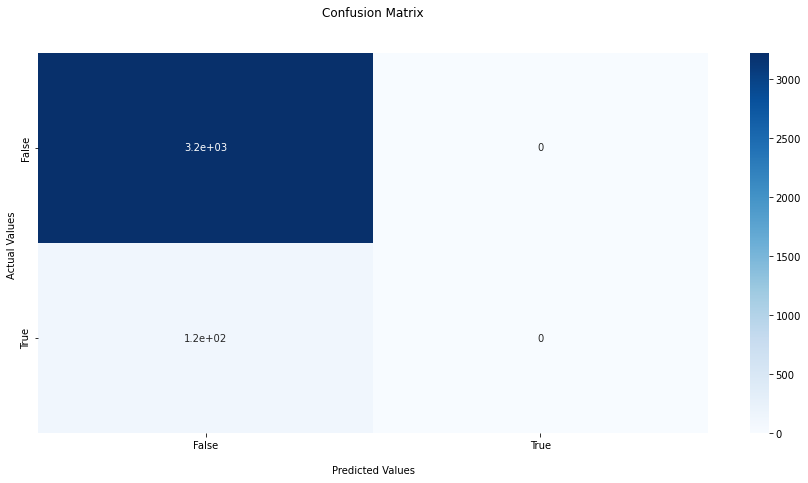

In [18]:
show_confusion_matrix(y_train, tree1.predict(X_train))

Teraz użyjemy Random Search

In [19]:
random = RandomizedSearchCV(estimator=tree, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state = 420)

random_result = random.fit(X_train, y_train)

print(f"Best score: {random_result.best_score_}")
print(f"Best parameters: {random_result.best_params_}")

Best score: 0.9652802019279827
Best parameters: {'splitter': 'best', 'max_depth': 5, 'criterion': 'gini', 'ccp_alpha': 0.05}


In [20]:
tree2 = DecisionTreeClassifier(ccp_alpha = 0,
                             criterion = 'gini',
                             max_depth = 3,
                             splitter = 'random')
tree2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=3, splitter='random')

In [21]:
print_scores(tree2)

ZBIÓR TRENINGOWY:
Model score: 0.9676743489973062
Precision score: 0.6666666666666666
Gini score: 0.56772520716386
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9643854748603352
Precision score: 0.0
Gini score: 0.4978370583994232


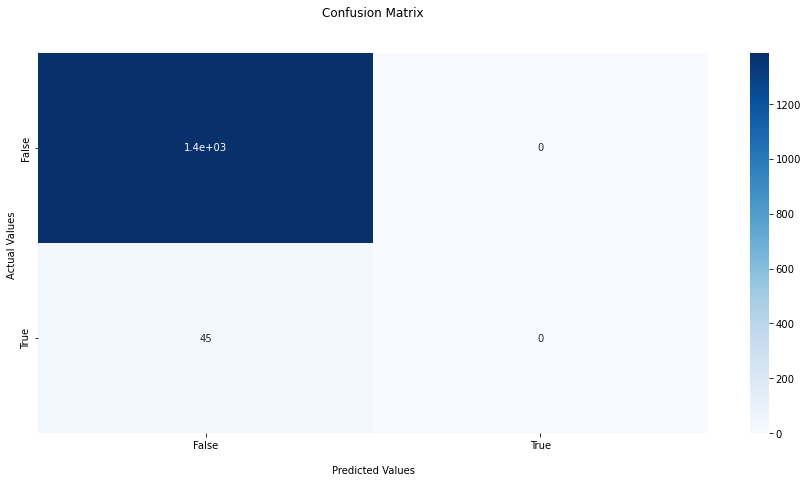

In [22]:
show_confusion_matrix(y_test, tree1.predict(X_test))

Udało się nieznacznie podbić wynik accuracy na zbiorze testowym, ale zapłaciliśmy za to cenę w postaci sporo niższego gini. Precision score jest równy zero. Sprawdziliśmy na macierzy konfucji, że jest to skutkiem tego, że każdej wartości przypisywany jest fałsz. Model w ogóle nie przewiduje prawdy. 

Sprawdzimy teraz, czy jeśli wybierzemy więcej parametrów i więcej wartości do wyboru to uzyskamy lepsze wyniki.

In [23]:
max_depth=[3, 4, 5, 6, 7, 8, 9, 10]
splitter = ["best", "random"]
criterion=["gini","entrophy"]
ccp_alpha=[0, 0.05, 0.1, 0.02]
min_samples_split=range(1,20)
min_samples_leaf=[0.5, 1, 1.5, 2]
max_features=["sqrt", "log2"]
param_grid = dict(max_depth=max_depth, splitter=splitter, criterion=criterion, min_samples_leaf=min_samples_leaf,
                  ccp_alpha=ccp_alpha, min_samples_split=min_samples_split, max_features=max_features)

In [24]:
# dlugo liczy
tree = DecisionTreeClassifier()
grid = GridSearchCV(estimator=tree, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.9679739176355808
Best parameters: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'} 


In [25]:
tree2 = DecisionTreeClassifier(ccp_alpha = 0,
                              criterion = 'gini',
                              max_depth = 4,
                              max_features ='log2',
                              min_samples_leaf = 1,
                              min_samples_split = 6,
                              splitter = 'random')
tree2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=4, max_features='log2',
                       min_samples_split=6, splitter='random')

In [26]:
print_scores(tree2)

ZBIÓR TRENINGOWY:
Model score: 0.9676743489973062
Precision score: 0.6
Gini score: 0.6009676557070301
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9643854748603352
Precision score: 0.3125
Gini score: 0.5515901626211648


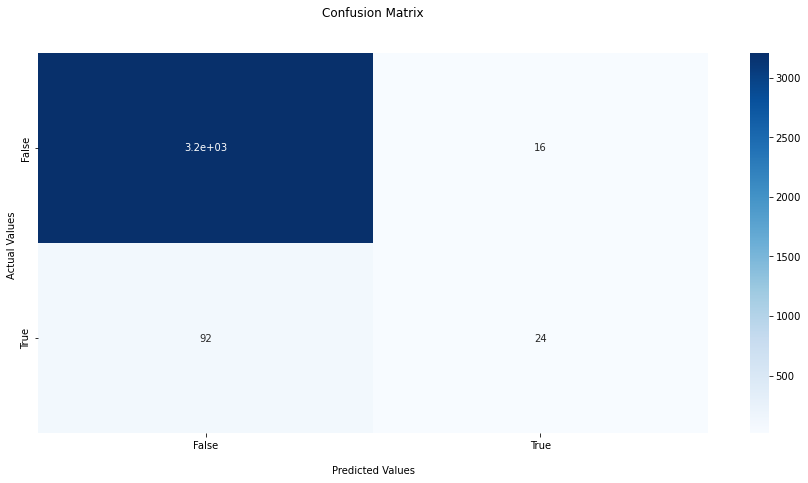

In [27]:
show_confusion_matrix(y_train, tree2.predict(X_train))

Widać, że w tym przypadku gini jest trochę lepsze niż przy pierwszym tuningu, ponieważ model zaczął przewidywać jakieś wartości *True*. Accuracy na zbiorze testowym pogorszyło się i model jest przetrenowany.

Sprawdzimy jakie wyniki dla takiego wyboru parametrów da zastosowanie Random Search:

In [28]:
tree = DecisionTreeClassifier()
random = RandomizedSearchCV(estimator=tree, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state = 100)

random_result = random.fit(X_train, y_train)

print(f"Best score: {random_result.best_score_}")
print(f"Best parameters: {random_result.best_params_}")

Best score: 0.9652802019279827
Best parameters: {'splitter': 'best', 'min_samples_split': 9, 'min_samples_leaf': 0.5, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini', 'ccp_alpha': 0.05}


In [29]:
tree3 = DecisionTreeClassifier(ccp_alpha = 0.05,
                              criterion = 'gini',
                              max_depth = 5,
                              max_features ='log2',
                              min_samples_leaf = 0.5,
                              min_samples_split = 9,
                              splitter = 'best')
tree3.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.05, max_depth=5, max_features='log2',
                       min_samples_leaf=0.5, min_samples_split=9)

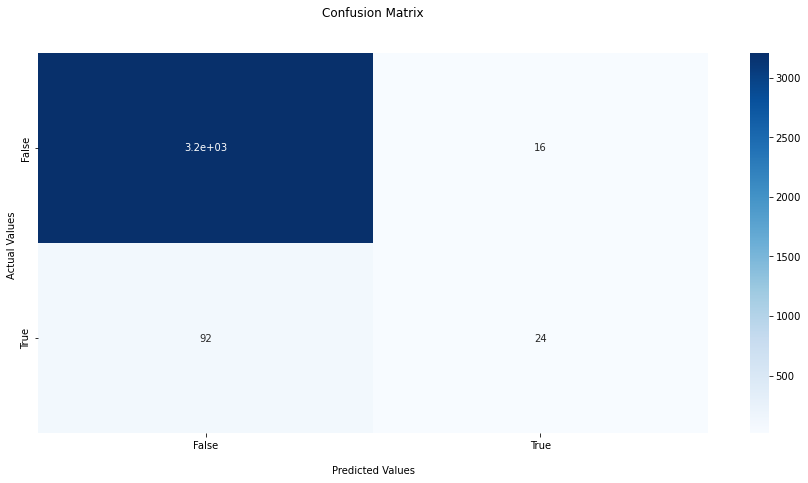

In [30]:
show_confusion_matrix(y_train, tree2.predict(X_train))

In [31]:
print_scores(tree3)

ZBIÓR TRENINGOWY:
Model score: 0.96527985633044
Precision score: 0.0
Gini score: 0.5
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9685754189944135
Precision score: 0.0
Gini score: 0.5


W tym przypadku model nie jest przetrenowany, wuniki w zbiorze treniniowym i testowym są bardzo zbliżone. Wartość 0 w precision score bierze się z tego, że wartości *true positive* jest bardzo mało w porównaiu do *true negative*.

### Random Forest

In [32]:
forest_base = RandomForestClassifier()
forest_base.fit(X_train, y_train)
pred = forest_base.predict(X_test)

In [33]:
print_scores(forest_base)

ZBIÓR TRENINGOWY:
Model score: 0.9997006884166417
Precision score: 1.0
Gini score: 0.9956896551724138
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9706703910614525
Precision score: 0.6666666666666666
Gini score: 0.5655851958663782


Podobnie jak w przypadku drzew decyzyjnych, acuuruacy score dla zbioru testowego jest bardzo wysoki, ale wydaje się, że model jest przetrenowany. Małe gini na zbiorze testowym to potwierdza.

Spróbujemy dobrać odpowiedznie hiperparametry:

In [34]:
max_depth=[3, 4, 5]
n_estimators = [80, 90, 100, 110, 120]
criterion=["gini","entrophy"]
min_samples_split = [2, 5, 10, 20, 50]
param_grid = dict(max_depth=max_depth, n_estimators = n_estimators, criterion=criterion, min_samples_split=min_samples_split)

In [35]:
forest = RandomForestClassifier()
grid = GridSearchCV(estimator=forest, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.9679730225647359
Best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 20, 'n_estimators': 90} 


In [36]:
forest = RandomForestClassifier(min_samples_split = 5,
                             criterion = 'gini',
                             max_depth = 3,
                             n_estimators = 110)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_split=5, n_estimators=110)

In [37]:
print_scores(forest)

ZBIÓR TRENINGOWY:
Model score: 0.9682729721640227
Precision score: 1.0
Gini score: 0.5431034482758621
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9699720670391061
Precision score: 1.0
Gini score: 0.5222222222222223


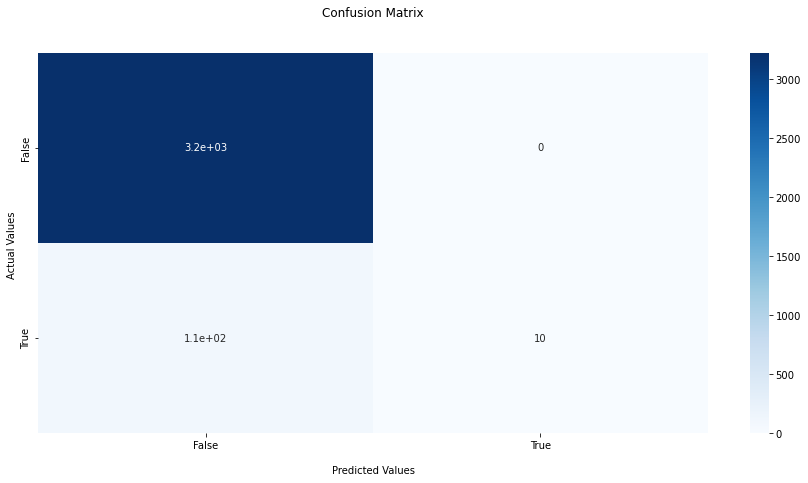

In [38]:
show_confusion_matrix(y_train, forest.predict(X_train))

Właściwie jedyne co się znacznie zmieniło to spadły wyniki dla zbioru testowego.

Sprawdźmy jakie hiperparametry wybierze random search:

In [39]:
forest = RandomForestClassifier()
random = RandomizedSearchCV(estimator=forest, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state = 100)

random_result = random.fit(X_train, y_train)

print(f"Best score: {random_result.best_score_}")
print(f"Best parameters: {random_result.best_params_}")

Best score: 0.9673742201695263
Best parameters: {'n_estimators': 90, 'min_samples_split': 10, 'max_depth': 3, 'criterion': 'gini'}


In [40]:
forest2 = RandomForestClassifier(min_samples_split = 2,
                                 criterion = 'gini',
                                 max_depth = 3,
                                 n_estimators = 90)
forest2.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=90)

In [41]:
print_scores(forest2)

ZBIÓR TRENINGOWY:
Model score: 0.9694702184974558
Precision score: 1.0
Gini score: 0.5603448275862069
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9706703910614525
Precision score: 1.0
Gini score: 0.5333333333333333


W tym przypadku zlikwidowaliśmy przetrenowanie.

### Support Vector Machine (SVM)

In [42]:
svm_base = SVC()
svm_base.fit(X_train, y_train)
pred = svm_base.predict(X_test)

In [43]:
print_scores(svm_base)

ZBIÓR TRENINGOWY:
Model score: 0.96527985633044
Precision score: 0.0
Gini score: 0.5
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9685754189944135
Precision score: 0.0
Gini score: 0.5


Model daje dobre wyniki accuracy, nie jest przetrenowany, jednak precision score jest zerowy. Sprawdźmy to na macierzy konfuzji.

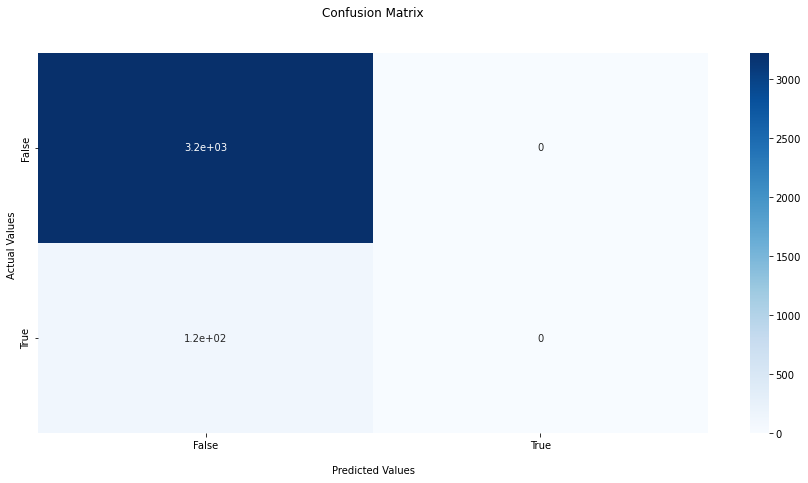

In [44]:
show_confusion_matrix(y_train, svm_base.predict(X_train))

Model ponownie nie przewiduje wartości *true*.

Spróbujmy teraz dobrać hiperparametry:

In [45]:
# Feature Scaling dla szybszego liczenia
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [46]:
C= [0.001, 0.01, 0.1,  1, 5]
kernel = ['linear', 'poly', 'sigmoid'] 
degree = [3,4,5]
gamma = ['scale', 'auto']
param_grid = dict(C=C, kernel=kernel, degree=degree, gamma=gamma)

In [47]:
# długo działa
svm_model = SVC()
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_train_scaled, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.9676754115088209
Best parameters: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 


In [48]:
svm_1 = SVC(C = 1, 
            degree = 3, 
            gamma = 'scale',
            kernel = 'poly')
svm_1.fit(X_train, y_train)

SVC(C=1, kernel='poly')

In [49]:
print_scores(svm_1)

ZBIÓR TRENINGOWY:
Model score: 0.96527985633044
Precision score: 0.0
Gini score: 0.5
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9685754189944135
Precision score: 0.0
Gini score: 0.5


Widać, że prkatycznie nic się nie zmieniło. 

Sprawdźmy jakie wyniki da zastosowanie random search:

In [50]:
svm_model = SVC()
random = RandomizedSearchCV(estimator=svm_model, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state = 100)

random_result = random.fit(X_train_scaled, y_train)

print(f"Best score: {random_result.best_score_}")
print(f"Best parameters: {random_result.best_params_}")

Best score: 0.967674516437976
Best parameters: {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 0.1}


In [51]:
svm_2 = SVC(C = 0.1, 
            degree = 4, 
            gamma = 'scale',
            kernel = 'poly')
svm_2.fit(X_train, y_train)

SVC(C=0.1, degree=4, kernel='poly')

In [52]:
print_scores(svm_2)

ZBIÓR TRENINGOWY:
Model score: 0.96527985633044
Precision score: 0.0
Gini score: 0.5
-------------------------------
ZBIÓR TESTOWY:
Model score: 0.9685754189944135
Precision score: 0.0
Gini score: 0.5


Wynik jest w tym przypakdu identyczny z tym poprzedni, wybranym przez grid search, jednak różnią się one dwoma hiperparamterami. Dla pierwszego *degree = 3*, *C = 1*, a w tym przypadku to *degree = 4*, *C = 0.1*.

## Porównanie modeli

In [53]:
def get_models():
    
    models = dict()
    models['decTree'] = DecisionTreeClassifier()
    
    models['decTree1'] = DecisionTreeClassifier(ccp_alpha = 0.05,
                                                  criterion = 'gini',
                                                  max_depth = 3,
                                                  splitter = 'best')
    models['decTree2'] = DecisionTreeClassifier(ccp_alpha = 0,
                                                  criterion = 'gini',
                                                  max_depth = 3,
                                                  splitter = 'random')
    models['decTree3'] = DecisionTreeClassifier(ccp_alpha = 0,
                                                  criterion = 'gini',
                                                  max_depth = 4,
                                                  max_features ='log2',
                                                  min_samples_leaf = 1,
                                                  min_samples_split = 6,
                                                  splitter = 'random')          
    models['decTree4'] = DecisionTreeClassifier(ccp_alpha = 0.05,
                                                  criterion = 'gini',
                                                  max_depth = 5,
                                                  max_features ='log2',
                                                  min_samples_leaf = 0.5,
                                                  min_samples_split = 9,
                                                  splitter = 'best')
    models['rf'] = RandomForestClassifier()
    models['rf1'] = RandomForestClassifier(min_samples_split = 5,
                                             criterion = 'gini',
                                             max_depth = 3,
                                             n_estimators = 110)
    models['rf2'] = RandomForestClassifier(min_samples_split = 2,
                                             criterion = 'gini',
                                             max_depth = 3,
                                             n_estimators = 90)
    models['svc'] = SVC()
    models['svc1'] = SVC(C = 1, 
                        degree = 3, 
                        gamma = 'scale',
                        kernel = 'poly')
    models['svc2'] = SVC(C = 0.1, 
                        degree = 4, 
                        gamma = 'scale',
                        kernel = 'poly')

    return models

In [54]:
def evaluate_model(model, X, y):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    return scores

In [55]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_test, y_test)
    results.append(scores)
    names.append(name)
    print('%8s mean-%.3f std-%.3f' % (name, np.mean(scores), np.std(scores)))

 decTree mean-0.949 std-0.013
decTree1 mean-0.969 std-0.003
decTree2 mean-0.967 std-0.008
decTree3 mean-0.966 std-0.006
decTree4 mean-0.969 std-0.003
      rf mean-0.971 std-0.005
     rf1 mean-0.970 std-0.004
     rf2 mean-0.970 std-0.004
     svc mean-0.969 std-0.003
    svc1 mean-0.969 std-0.003
    svc2 mean-0.969 std-0.003


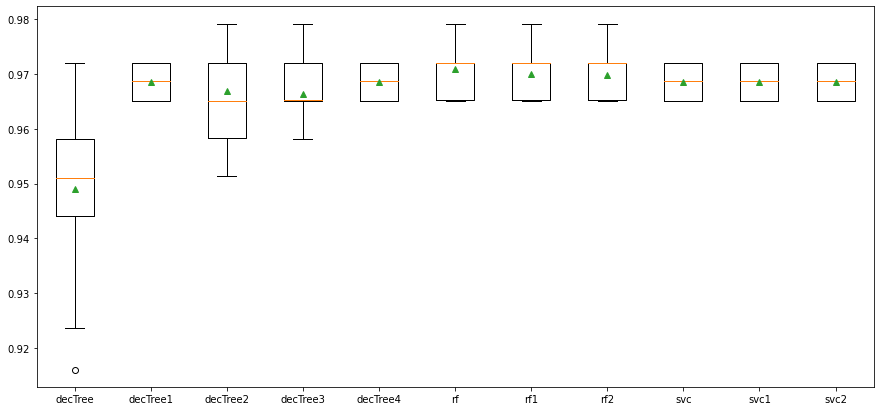

In [56]:
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Podsumowanie

* Dodanie większej ilości parametrów do testowania nie zawsze jest opłacalne - liczy się dłużej, a wyniki niekoniecznie muszą być dużo lepsze, w rozważanym przez nas przypadku otrzymalismy nawet gorsze wyniki. Nasz zbiór danych nie jest szczególnie duży, dlatego różnice w czasie nie były duże, ale już zauważalne. W przypadku większego zbioru mogłoby to stanowić problem i wtedy warto się zastanowić czy zależy nam na nieznacznym podniesieniu predykcyjności
* Random search jest niemal tak samo dobry jak grid serach, w jednym przypadku dał dokładnie ten sam wynik, w innych zbliżony, lub nawet bardziej optymalny
* Sposód zastosowanych modeli, wnioskując po boxplotach, najbardziej optymlanym wydaje się być Random Forest z dodanymi hiperparametrami.
